In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run ../modules/run_or_load_decorator.py
%run ../modules/MDS.py

In [72]:
protein_name = 'fxa'

In [73]:
path_to_file = '../../../FXa/ANALISIS/1_Fetching_and_generating_data/TABLA_MTDATA_FXA_136_crys_LIGS_INFO.json'
df_prot = pd.read_json(path_to_file)

In [74]:
df_dims = pd.read_pickle(
    '../../../FXa/ANALISIS/3_Protein_Crystal_Ensembles/FXA_DIMS_reduced_TABLE_dashApp.obj')
# update the df with the mds axis
# Pocket shape
df_prot['vol_x'] = df_dims['mds_vol_pkt_x']
df_prot['vol_y'] = df_dims['mds_vol_pkt_y']
# pocket residues RMSD
df_prot['secres_x'] = df_dims['mds_sec_x']
df_prot['secres_y'] = df_dims['mds_sec_y']

In [75]:
mask = df_prot.Title.str.contains('active')
df_prot[mask]

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,vol_x,vol_y,secres_x,secres_y
2uwl,selective and dual action orally active inhibi...,2007-04-24,2,A,1.90,-,47.950820,2,"[235, 21]","[[1, 235], [469, 489]]",1,[895],895,390.0,0.033919,-0.067396,-0.366916,-0.084892
2uwo,selective and dual action orally active inhibi...,2007-05-08,2,A,1.75,-,47.540984,3,"[235, 3, 21]","[[1, 235], [297, 299], [469, 489]]",1,[701],701,402.0,-0.037119,-0.061262,-1.323106,1.534121
3kl6,discovery of tetrahydropyrimidin-2(1h)-one der...,2009-12-01,2,A,1.45,-,47.540984,2,"[235, 23]","[[1, 235], [467, 489]]",3,"[443, CA, EDO]",443,418.0,-0.010450,0.044811,-0.344398,-1.686337


In [76]:
# Extra features to get volume or surface area
df_extra = pd.read_pickle(f'./TABLE_Confs_Features_and_performances_{protein_name}.pkl')
df_extra

# Adding to the main df
df_prot['volume'] = df_extra['Pk. Volume']
df_prot['surf_area'] = df_extra['Pk. Surf. Area']


# ROC-AUC single performance
df_prot['AUC-ROC'] = df_extra['AUC-ROC']

In [77]:
# *******************
# Pocket Residues 
# *******************
dir_volumen_results = f'./pocket_info/{protein_name}/'

vol_tan_mtx = pd.read_csv(dir_volumen_results + 'POVME_Tanimoto_matrix.csv', header=None)
vol_tan_col_mtx = pd.read_csv(dir_volumen_results + 'POVME_Tanimoto_matrix_colored.csv', header=None)
vol_tan_hyfb_mtx = pd.read_csv(dir_volumen_results +'POVME_Tanimoto_matrix_hydrophobic.csv', header=None)

# MDS using only col Tanimoto
mds_vol_pkt = cMDS(1 - vol_tan_mtx)[0]
# update the df with the mds axis
df_prot['x'] = mds_vol_pkt[0]
df_prot['y'] = mds_vol_pkt[1]

In [78]:
# Open RFE_estimator
# filename = f'../6_Machine_Learning_Models/ml_models/RFECV_selector_{model_name}_{dataset}_{split}_split.joblib'
filename = f'./rfe_selectors/RFE_xgb_{protein_name}.joblib'
# RFE selector LogReg Random split
rfe_selector = joblib.load(filename)
rfe_selector.ranking_
df_ranks = pd.DataFrame({'pdb_id': df_prot.index, 'rfe_ranking': rfe_selector.ranking_})
df_ranks = df_ranks.sort_values('rfe_ranking')
df_ranks = df_ranks.set_index('pdb_id')

# update the df with the rank values
df_prot = df_prot.merge(df_ranks, left_index=True, right_index=True)\
            .sort_values('rfe_ranking')

In [79]:
# To be able to plot confs with no inhibitors => NA == 10
df_prot['Inhib_mass_num'] = pd.to_numeric(df_prot['Inhib_mass']).\
                        fillna(10) ** 2
df_prot['volume'] = df_prot['volume']

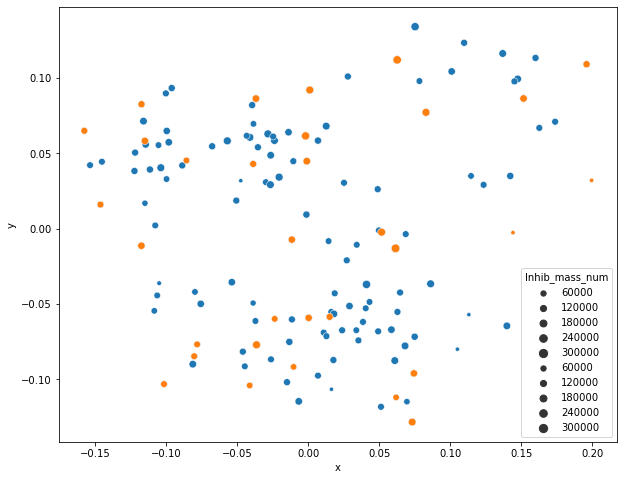

In [80]:
df_selected = df_prot.sort_values('rfe_ranking').head(32)

fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x='x', y='y', data=df_prot, 
                size='Inhib_mass_num')
sns.scatterplot(x='x', y='y', data=df_selected, 
                size='Inhib_mass_num')
plt.show()

In [89]:
%load_ext rpy2.ipython

In [90]:
df_to_R = df_prot[['rfe_ranking', 'vol_x', 'vol_y', 'volume']]

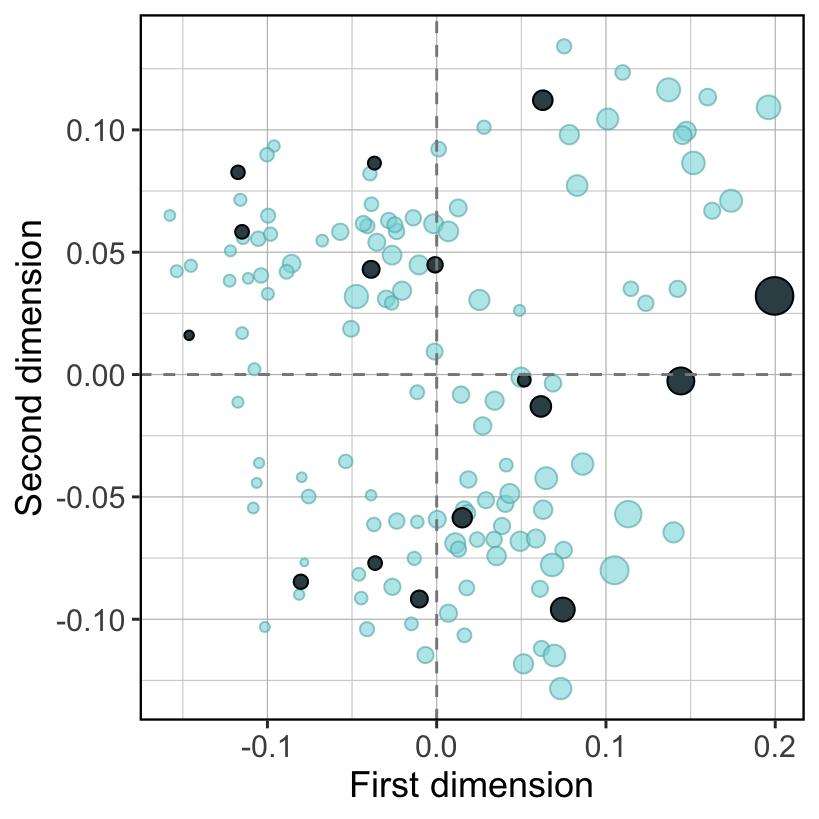

In [98]:
%%R -i df_to_R -w 4.1 -h 4.1 --units in -r 200
library(ggplot2)
library(tidyverse)


df <- df_to_R %>% 
    mutate(volume.T = (volume / 200) **2 )
top <- 16

p = ggplot() +
    (df %>% 
     geom_point(
         mapping=aes(x=vol_x, y=vol_y, 
                 size=volume.T),
                 stroke=0.5, shape=21,
                 colour='#61B0B3', fill='#87DADE', 
                 alpha=0.6)) + 
    (df %>% 
     filter(rfe_ranking <= top) %>%
     geom_point(mapping=aes(x=vol_x, y=vol_y,
                           size=volume.T), 
                color='black', fill='#374E55',
                shape=21, stroke=0.5)) +
#     coord_fixed() +
    geom_hline(yintercept= 0, linetype="dashed", color="#888888") +
    geom_vline(xintercept= 0, linetype="dashed", color="#888888") +
    theme(legend.position = 'none', 
              panel.border = element_rect(colour = "black", fill=NA, size=0.8),
              panel.background = element_rect(fill = "white",
                                    colour = "white",
                                    size = 1, linetype = "solid"),
              axis.title.y = element_text(size=13),
              axis.text.y=element_text(size=11, angle=0),
              panel.grid.major.y = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.y = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              axis.title.x = element_text(size=13),
              axis.text.x=element_text(size=11, angle=0),
              panel.grid.major.x = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.x = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              plot.title = element_text(hjust = 0.5, size=11)
             ) + 
             scale_radius() +
             labs(x = 'First dimension', y = 'Second dimension')

protein_name <- 'fxa'
methodology <- 'mds_plot'
filename <- paste0('images/fxa/', paste(protein_name, methodology,  '.pdf', sep='_'))
ggsave(filename, plot=p, width=4.1, height= 4.1) 
p

In [99]:
df_ = df_prot.copy()
df_['top_mask'] = [2 if i < 16 else 1 for i in df_['rfe_ranking']]
df_ = df_[['AUC-ROC', 'top_mask']].melt(id_vars='top_mask')

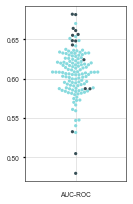

In [101]:
import matplotlib.ticker as ticker

sns.set(font_scale=0.6, style='whitegrid')

df_ = df_prot.copy()
df_['top_mask'] = [1 if i < 16 else 0 for i in df_['rfe_ranking']]

df_ = df_[['AUC-ROC', 'top_mask']].melt(id_vars='top_mask')

fig, ax = plt.subplots(figsize=(1.8, 3.22))
# fig, ax = plt.subplots(figsize=(4.1, 6.2))
sns.swarmplot(y='value', x='variable', size=3.2,
              hue='top_mask', data=df_, ax=ax,
             palette=('#87DADE', '#374E55'))
# ax.set_ylim((0.49, 0.7))
ax.set_yticks(np.arange(0.5, 0.70, .05))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax.yaxis.tick_left()
ax.get_legend().remove()
ax.tick_params(length=2, color='black', axis='y')
ax.grid(True, linewidth=0.5)
ax.set(xlabel='', ylabel='')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.55)
    ax.spines[axis].set_edgecolor('black')
plt.savefig('./images/fxa/swarm_plot_confs.pdf') 
plt.show()

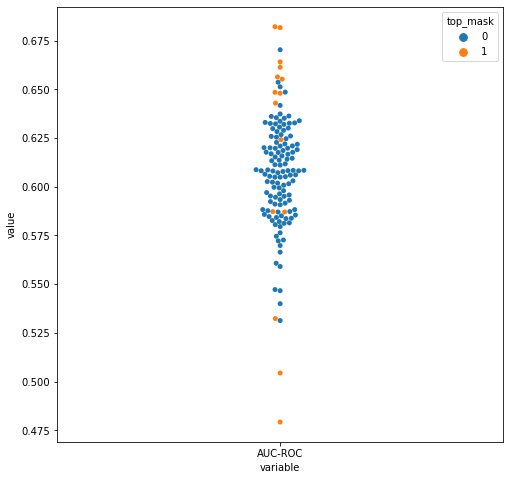

,top_mask,variable,value
0,1,AUC-ROC,0.64797
1,1,AUC-ROC,0.66406
2,1,AUC-ROC,0.47927
3,1,AUC-ROC,0.66129
4,1,AUC-ROC,0.64844
...,...,...,...
131,0,AUC-ROC,0.61768
132,0,AUC-ROC,0.58263
133,0,AUC-ROC,0.58210
134,0,AUC-ROC,0.61132


In [88]:
df_ = df_prot.copy()
df_['top_mask'] = [1 if i < 16 else 0 for i in df_['rfe_ranking']]

df_ = df_[['AUC-ROC', 'top_mask']].melt(id_vars='top_mask')

fig, ax = plt.subplots(figsize=(8,8))
sns.swarmplot(y='value', x='variable', hue='top_mask', data=df_)
plt.show()
df_

In [82]:
df_prot.sort_values('rfe_ranking')

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,...,vol_y,secres_x,secres_y,volume,surf_area,AUC-ROC,x,y,rfe_ranking,Inhib_mass_num
1iqe,human coagulation factor xa in complex with m5...,2003-09-23,2,A,2.90,-,48.155738,2,"[235, 20]","[[1, 235], [470, 489]]",...,0.112110,-2.582510,1.382892,978.0,678.0,0.64797,0.062686,0.112110,1,302500.0
1lpk,crystal structure of fxa in complex with 125.,2003-05-08,2,B,2.20,-,47.950820,2,"[235, 21]","[[1, 235], [469, 489]]",...,-0.084679,-0.692402,-1.251708,898.0,574.0,0.66406,-0.080237,-0.084679,2,161604.0
2p3f,crystal structure of the factor xa/nap5 complex,2007-11-06,3,H,3.10,-,48.155738,2,"[235, 20]","[[1, 235], [470, 489]]",...,-0.002626,-0.352383,1.971848,1079.0,636.0,0.47927,0.144247,-0.002626,3,100.0
4btu,factor xa in complex with the dual thrombin-fx...,2013-12-18,2,B,2.37,-,47.950820,2,"[235, 21]","[[1, 235], [469, 489]]",...,-0.002301,-2.572621,0.418434,873.0,593.0,0.66129,0.051729,-0.002301,4,252004.0
2vwl,aminopyrrolidine factor xa inhibitor,2009-07-07,2,A,1.80,-,47.950820,2,"[235, 21]","[[1, 235], [469, 489]]",...,0.082652,0.021675,-0.501818,885.0,573.0,0.64844,-0.117361,0.082652,5,183184.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2y80,structure and property based design of factor ...,2011-03-16,2,A,1.90,-,47.950820,2,"[235, 21]","[[1, 235], [469, 489]]",...,-0.042354,-0.455017,0.598679,1012.0,599.0,0.61768,0.064730,-0.042354,132,178084.0
2vvc,aminopyrrolidine factor xa inhibitor,2009-07-07,2,A,1.95,-,47.745902,2,"[235, 22]","[[1, 235], [467, 488]]",...,0.050552,0.033197,1.464566,846.0,618.0,0.58263,-0.121854,0.050552,133,183184.0
2h9e,crystal structure of fxa/selectide/napc2 terna...,2007-02-13,4,H,2.20,-,47.745902,2,"[235, 22]","[[1, 235], [467, 488]]",...,-0.036160,2.069010,-2.220690,832.0,533.0,0.58210,-0.104917,-0.036160,134,23716.0
2y5g,factor xa - cation inhibitor complex,2011-12-28,2,A,1.29,-,47.745902,2,"[235, 22]","[[1, 235], [467, 488]]",...,-0.101893,3.487939,1.031696,876.0,566.0,0.61132,-0.014904,-0.101893,135,183184.0
